# XOR (TensorFlow)

[![Open in Colab](https://lab.aef.me/files/assets/colab-badge.svg)](https://colab.research.google.com/github/adamelliotfields/lab/blob/main/files/tf/xor.ipynb)
[![Open in Kaggle](https://lab.aef.me/files/assets/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/adamelliotfields/lab/blob/main/files/tf/xor.ipynb)
[![Render nbviewer](https://lab.aef.me/files/assets/nbviewer_badge.svg)](https://nbviewer.org/github/adamelliotfields/lab/blob/main/files/tf/xor.ipynb)

Given the following table:

```markdown
| A | B | A ^ B |
|---|---|-------|
| 0 | 0 | 0     |
| 0 | 1 | 1     |
| 1 | 0 | 1     |
| 1 | 1 | 0     |
```

We can train a neural network to predict the XOR of two binary inputs.

In Python, XOR is represented by the caret `^`. In TensorFlow, XOR is implemented by the `tf.math.logical_xor` function.

The traditional `OR` operator is the _inclusive or_. So, `True or True` is `True`. The XOR operation is _exclusive_, so `True ^ True` is `False` (but `True ^ False` is `True`).

The significance of this problem is that it is not linearly separable. This means if you were to plot the data on a graph, you would not be able to draw a straight line between the two classes. Since neural networks are composed of linear operations, they require non-linear activation functions to solve problems like this. Early neural networks 

**Notes**

Using `Sequential` here, but most other notebooks use the [functional API](https://keras.io/guides/functional_api/).

In [1]:
%matplotlib inline

In [2]:
import math

import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from keras import Input, Sequential, callbacks, initializers, layers, optimizers, random

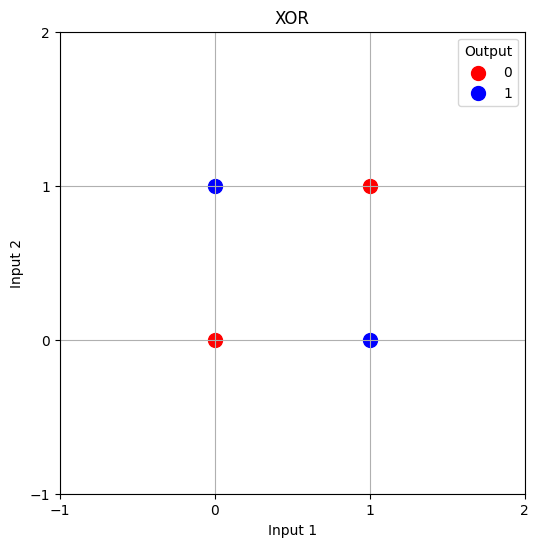

In [3]:
# plot xor
inputs = [(0, 0), (0, 1), (1, 0), (1, 1)]
outputs = [0, 1, 1, 0]

# separate into two lists for plotting
x_vals = [x[0] for x in inputs]
y_vals = [x[1] for x in inputs]

# scatter
plt.figure(figsize=(6, 6))
for i in range(len(inputs)):
    if outputs[i] == 0:
        plt.scatter(x_vals[i], y_vals[i], color="red", s=100, label="0" if i == 0 else "")
    else:
        plt.scatter(x_vals[i], y_vals[i], color="blue", s=100, label="1" if i == 1 else "")

# labels
plt.xlabel("Input 1")
plt.ylabel("Input 2")
plt.title("XOR")
plt.xticks([-1, 0, 1, 2])
plt.yticks([-1, 0, 1, 2])
plt.legend(title="Output")
plt.grid(True);

In [4]:
# parameters
EPOCHS = 100
BATCH_SIZE = 4
LEARNING_RATE = 0.01
# WEIGHT_DECAY = 0.01


# custom progress bar
class ProgressBar(callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params["epochs"]

    def on_epoch_end(self, epoch, logs=None):
        # every 10th
        if epoch == 0 or (epoch + 1) % 10 == 0:
            print(
                f"Epoch {epoch + 1}/{self.epochs}: loss={logs['loss']:.4f}, accuracy={logs['accuracy']:.4f}"
            )


# custom learning rate schedule
def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * math.exp(-0.1)


# weight initialization
seed = random.SeedGenerator(seed=42)
initializer = initializers.HeNormal(seed=seed)

# optimizer = optimizers.AdamW(learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
optimizer = optimizers.Lion(learning_rate=LEARNING_RATE)

# xor returns 1 if inputs are not equal and 0 otherwise
X = tf.constant([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=tf.float32)
y = tf.constant([[0], [1], [1], [0]], dtype=tf.float32)

# model
model = Sequential(
    [
        Input(shape=(2,)),
        layers.Dense(32, activation="mish", kernel_initializer=initializer),
        layers.Dense(32, activation="mish", kernel_initializer=initializer),
        # linear for regression
        # sigmoid for binary classification
        # softmax for multi-class classification
        layers.Dense(1, activation="sigmoid"),
    ]
)

model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(
    X,
    y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=0,
    callbacks=[
        callbacks.LearningRateScheduler(lr_schedule),
        callbacks.EarlyStopping(monitor="loss", min_delta=0.001, patience=20),
        ProgressBar(),
    ],
)

Epoch 1/100: loss=0.8213, accuracy=0.5000
Epoch 10/100: loss=0.1872, accuracy=1.0000
Epoch 20/100: loss=0.0492, accuracy=1.0000
Epoch 30/100: loss=0.0249, accuracy=1.0000
Epoch 40/100: loss=0.0186, accuracy=1.0000
Epoch 50/100: loss=0.0165, accuracy=1.0000
Epoch 60/100: loss=0.0158, accuracy=1.0000
Epoch 70/100: loss=0.0155, accuracy=1.0000


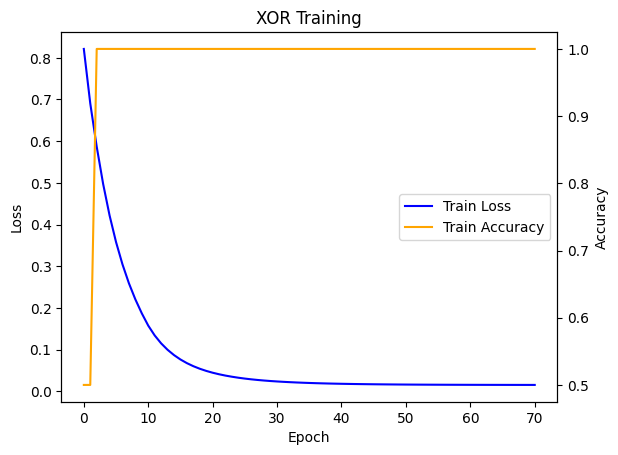

In [5]:
_, ax1 = plt.subplots()

# loss
ax1.set_ylabel("Loss")
ax1.set_xlabel("Epoch")
sns.lineplot(
    history.history["loss"],
    ax=ax1,
    label="Train Loss",
    color="blue",
    dashes=False,
    legend=False,
)

# accuracy
ax2 = ax1.twinx()
ax2.set_ylabel("Accuracy")
sns.lineplot(
    history.history["accuracy"],
    ax=ax2,
    label="Train Accuracy",
    color="orange",
    dashes=False,
    legend=False,
)

# combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc="center right")
plt.title("XOR Training");

## Demo

In [ ]:
output = widgets.Output()
dropdown_a = widgets.Dropdown(options=[0, 1], value=0)
dropdown_b = widgets.Dropdown(options=[0, 1], value=0)
submit = widgets.Button(description="Predict", button_style="success")

dropdown_a.layout.width = "60px"
dropdown_b.layout.width = "60px"
submit.layout.width = "124px"

# placeholder
with output:
    print("Prediction: ?")


def on_submit(_):
    with output:
        output.clear_output()
        print("Prediction: ?")
        prediction = model.predict(
            tf.constant([[dropdown_a.value, dropdown_b.value]]),
            verbose=0,
        )
        output.clear_output()
        # prediction is a 2D array (matrix)
        print(f"Prediction: {int(round(prediction[0][0]))}")


submit.on_click(on_submit)
widgets.VBox(
    [
        output,
        widgets.HBox([dropdown_a, dropdown_b]),
        submit,
    ]
)